In [ ]:
import os
import re
import pandas as pd

def safe_extract(pattern, content, convert_func=str, default=None):
    """Safely extract data using regex pattern with a default value if not found"""
    match = re.search(pattern, content)
    if match:
        try:
            return convert_func(match.group(1))
        except (ValueError, TypeError):
            return default
    return default

def process_output_files(directory):
    # Dictionary to store all the data
    data_dict = {}
    
    # Regular expressions for file name and data extraction
    file_pattern = re.compile(r'output_k(\d+)_missing(\d+)\.txt')
    
    # Process each file in the directory
    for filename in os.listdir(directory):
        match = file_pattern.match(filename)
        if match:
            k_val, missing_val = match.groups()
            row_id = f"k{k_val}_missing{missing_val}"
            
            try:
                with open(os.path.join(directory, filename), 'r') as file:
                    # Read file content and remove everything after "Full reconstructed sequence: "
                    content = file.read()
                    if "Full reconstructed sequence: " in content:
                        content = content.split("Full reconstructed sequence: ")[0]
                    
                    # Extract data using safe extraction
                    data = {
                        'k_value': safe_extract(r'K value: (\d+)', content, int, None),
                        'missing_percent': safe_extract(r'Percentage of missing kmers: ([\d.]+)', content, float, None),
                        'runtime': safe_extract(r'Runtime: ([\d.]+)', content, float, None),
                        'score': safe_extract(r'Score: ([\d.]+)', content, float, None),
                        'identity': safe_extract(r'Identity: ([\d.]+)', content, float, None),
                        'rotation': safe_extract(r'Rotation needed: (\d+)', content, int, None),
                        'original_seq': safe_extract(r'Original sequence snippet: ([A-Z]+)', content, str, ""),
                        'reconstructed_seq': safe_extract(r'Reconstructed sequence snippet: ([A-Z]+)', content, str, "")
                    }
                    
                    # Remove None values for better DataFrame handling
                    data = {k: v for k, v in data.items() if v is not None}
                    data_dict[row_id] = data
                    
            except Exception as e:
                print(f"Error processing file {filename}: {str(e)}")
                continue

    # Convert dictionary to DataFrame
    df = pd.DataFrame.from_dict(data_dict, orient='index')
    
    # Sort index to ensure consistent ordering
    if not df.empty:
        df.sort_index(inplace=True)
    
    return df

In [ ]:

# Example usage:
if __name__ == "__main__":
    # Replace with your directory path
    directory_path = "../Varied-Kmer-Assembly-and-Analysis/output"
    df = process_output_files(directory_path)
    
    # Display first few rows and info about the DataFrame
    print("\nDataFrame Info:")
    print(df.info())
    print("\nFirst few rows:")
    print(df.head())
    
    # Optional: Check for missing values
    print("\nMissing values count:")
    print(df.isnull().sum())

In [ ]:
df.head(100)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plot_filter = 'k50'

# Filter for k10 data
k10_data = df[df.index.str.startswith(plot_filter + '_')]

# Extract missing percentages from index
missing_percentages = k10_data.index.str.extract(r'missing(\d+)').astype(int)

# Create the scatter plot
plt.figure(figsize=(10, 6))

# Create scatter plot with size and color based on identity
scatter = plt.scatter(missing_percentages, 
                     k10_data['identity'],
                     s=k10_data['identity'] * 10,  # Size proportional to identity
                     c=k10_data['identity'],       # Color based on identity
                     cmap='viridis',               # Color map
                     alpha=0.6)                    # Some transparency

# Add colorbar
plt.colorbar(scatter, label='Identity Value')

# Customize the plot
plt.title('{} Performance Across Missing Percentages'.format(plot_filter), fontsize=12)
plt.xlabel('Missing Percentage', fontsize=10)
plt.ylabel('Identity Value', fontsize=10)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def extract_k_and_missing(df):
    """Extract k-values and missing percentages from index"""
    k_values = df.index.str.extract(r'k(\d+)').astype(int)
    missing_values = df.index.str.extract(r'missing(\d+)').astype(int)
    return k_values, missing_values

def plot_kmer_analysis(df, save_path=None):
    """
    Generate comprehensive visualizations for kmer analysis data
    
    Parameters:
    df : pandas DataFrame
        The input DataFrame containing kmer analysis results
    save_path : str, optional
        If provided, saves plots to this directory
    """
    # Extract k-values and missing percentages
    k_values, missing_values = extract_k_and_missing(df)
    df = df.copy()
    df['k_from_index'] = k_values
    df['missing_from_index'] = missing_values
    
    # Set up the plotting style
    plt.style.use('seaborn')
    
    # 1. Identity Heatmap
    plt.figure(figsize=(12, 8))
    identity_pivot = df.pivot(index='k_from_index', 
                            columns='missing_from_index', 
                            values='identity')
    sns.heatmap(identity_pivot, 
                cmap='viridis', 
                annot=True, 
                fmt='.1f',
                cbar_kws={'label': 'Identity Value'})
    plt.title('Identity Values Across K-mers and Missing Percentages')
    plt.xlabel('Missing Percentage')
    plt.ylabel('K-mer Value')
    if save_path:
        plt.savefig(f"{save_path}/identity_heatmap.png")
    plt.show()
    
    # 2. Runtime Analysis
    plt.figure(figsize=(12, 6))
    for missing in sorted(df['missing_from_index'].unique()):
        mask = df['missing_from_index'] == missing
        plt.plot(df[mask]['k_from_index'], 
                df[mask]['runtime'], 
                'o-', 
                label=f'Missing {missing}%',
                alpha=0.7)
    plt.title('Runtime vs K-mer Value for Different Missing Percentages')
    plt.xlabel('K-mer Value')
    plt.ylabel('Runtime (seconds)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    if save_path:
        plt.savefig(f"{save_path}/runtime_analysis.png")
    plt.show()
    
    # 3. Score Distribution
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='missing_from_index', y='score', data=df)
    plt.title('Score Distribution by Missing Percentage')
    plt.xlabel('Missing Percentage')
    plt.ylabel('Score')
    if save_path:
        plt.savefig(f"{save_path}/score_distribution.png")
    plt.show()
    
    # 4. Identity vs Score Scatter
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df['identity'], 
                         df['score'],
                         c=df['k_from_index'],
                         s=100,
                         alpha=0.6,
                         cmap='viridis')
    plt.colorbar(scatter, label='K-mer Value')
    plt.title('Identity vs Score (colored by K-mer value)')
    plt.xlabel('Identity')
    plt.ylabel('Score')
    plt.grid(True, alpha=0.3)
    if save_path:
        plt.savefig(f"{save_path}/identity_score_scatter.png")
    plt.show()
    
    # 5. Rotation Analysis
    plt.figure(figsize=(12, 6))
    rotation_pivot = df.pivot(index='k_from_index', 
                            columns='missing_from_index', 
                            values='rotation')
    sns.heatmap(rotation_pivot, 
                cmap='coolwarm', 
                center=0,
                annot=True, 
                fmt='.0f')
    plt.title('Rotation Values Across K-mers and Missing Percentages')
    plt.xlabel('Missing Percentage')
    plt.ylabel('K-mer Value')
    if save_path:
        plt.savefig(f"{save_path}/rotation_heatmap.png")
    plt.show()

def plot_single_k_analysis(df, k_value):
    """
    Generate detailed analysis plots for a specific k-value
    
    Parameters:
    df : pandas DataFrame
        The input DataFrame containing kmer analysis results
    k_value : int
        The k-value to analyze
    """
    k_data = df[df.index.str.startswith(f'k{k_value}_')]
    missing_values = k_data.index.str.extract(r'missing(\d+)').astype(int)
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Analysis for K-mer Value {k_value}', fontsize=16)
    
    # 1. Identity vs Missing Percentage
    ax1 = axes[0, 0]
    scatter1 = ax1.scatter(missing_values, 
                          k_data['identity'],
                          s=k_data['identity']*5,
                          c=k_data['score'],
                          cmap='viridis',
                          alpha=0.7)
    ax1.set_title('Identity vs Missing Percentage')
    ax1.set_xlabel('Missing Percentage')
    ax1.set_ylabel('Identity')
    ax1.grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=ax1, label='Score')
    
    # 2. Runtime vs Missing Percentage
    ax2 = axes[0, 1]
    ax2.plot(missing_values, k_data['runtime'], 'o-', color='red')
    ax2.set_title('Runtime vs Missing Percentage')
    ax2.set_xlabel('Missing Percentage')
    ax2.set_ylabel('Runtime (seconds)')
    ax2.grid(True, alpha=0.3)
    
    # 3. Score vs Missing Percentage
    ax3 = axes[1, 0]
    ax3.plot(missing_values, k_data['score'], 'o-', color='green')
    ax3.set_title('Score vs Missing Percentage')
    ax3.set_xlabel('Missing Percentage')
    ax3.set_ylabel('Score')
    ax3.grid(True, alpha=0.3)
    
    # 4. Rotation vs Missing Percentage
    ax4 = axes[1, 1]
    ax4.plot(missing_values, k_data['rotation'], 'o-', color='purple')
    ax4.set_title('Rotation vs Missing Percentage')
    ax4.set_xlabel('Missing Percentage')
    ax4.set_ylabel('Rotation')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



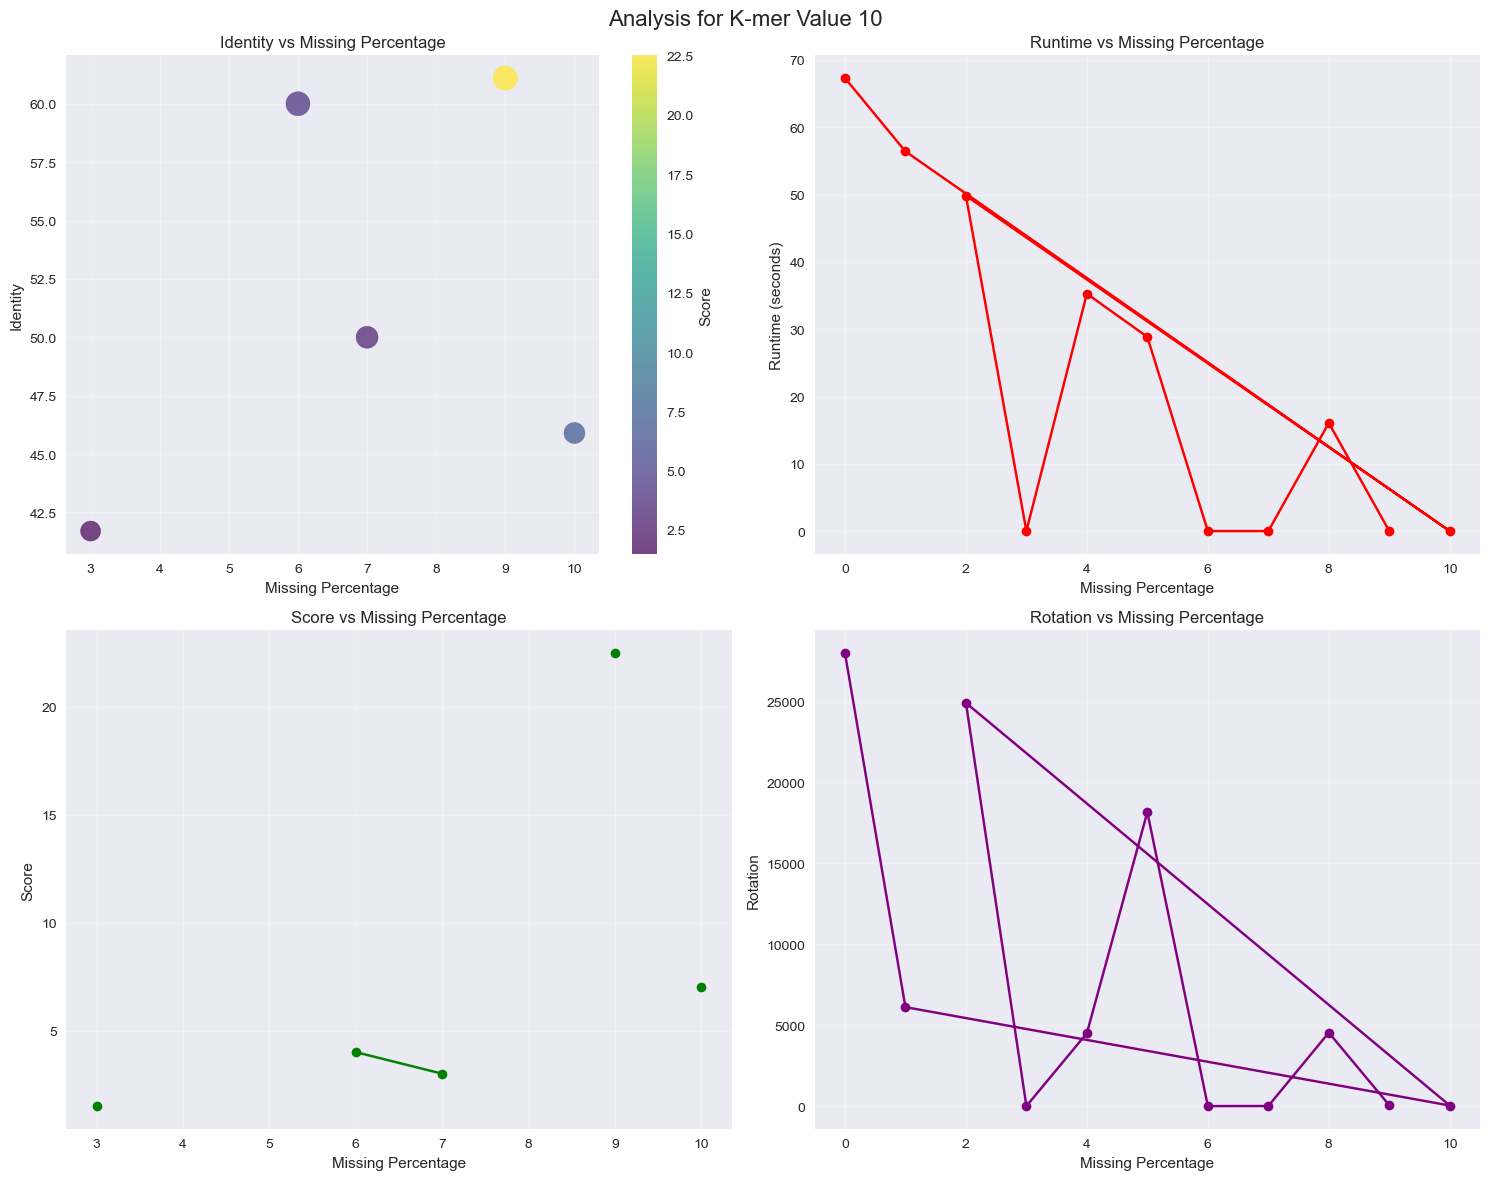

In [40]:
# For all data
# plot_kmer_analysis(df)

# # For specific k-value analysis
plot_single_k_analysis(df, 10)  # or any other k-value